# Uplift

### 00. data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('./data/hillstrom_clean.csv')

labels_mapping = {"control": 0, "womans_email": 1, "mens_email": 2}

- 해당 데이터는 experimental data이고 treatment는 3가지이다.
  - control 그룹, mens관련 상품 이메일을 받은 그룹, womans관련 상품 이메일을 받은 그룹

In [3]:
print(f'data.shape={data.shape}')

data.shape=(64000, 15)


In [4]:
data.head(3)

,recency,history,mens,womens,newbie,visit,conversion,spend,zip_code__rural,zip_code__surburban,zip_code__urban,channel__multichannel,channel__phone,channel__web,treatment
0,10,142.44,1,0,0,0,0,0.0,0,1,0,0,1,0,1
1,6,329.08,1,1,1,0,0,0.0,1,0,0,0,0,1,0
2,7,180.65,0,1,1,0,0,0.0,0,1,0,0,0,1,1


In [5]:
data = data.drop(['zip_code__urban', 'channel__web'], axis=1)

## 01. check randomization

In [6]:
data_X = data.drop(['visit', 'conversion', 'spend', 'treatment'], axis=1)
data_Y = data['spend']
data_T = data['treatment']

In [7]:
# treatment 비율
data_T.value_counts()

1    21387
2    21307
0    21306
Name: treatment, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train_eda, X_test_eda, T_train_eda, T_test_eda = train_test_split(data_X, data_T, test_size=.5)

In [10]:
from lightgbm import LGBMClassifier

In [11]:
lgbm_eda = LGBMClassifier()
lgbm_eda.fit(X_train_eda, T_train_eda)

LGBMClassifier()

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
T_pred_eda = lgbm_eda.predict(X_test_eda)
accuracy_score(T_test_eda, T_pred_eda)

0.33003125

- acc가 treatment의 비율과 비슷하다.
- 즉, feature들을 통해서 treatment을 맞출 수 없다. random이다.

In [14]:
import numpy as np

In [15]:
# empirical confidence

random_scores = []
test_eda_sample_size = T_test_eda.shape[0]

for _ in range(10000):
    random_scores.append(
        (np.random.choice([0, 1, 2], test_eda_sample_size) == np.random.choice([0, 1, 2], test_eda_sample_size)).mean())
np.quantile(random_scores, .025), np.quantile(random_scores, .975)

(0.32821875, 0.3385)

## 02. causal effect

In [16]:
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(
    data_X,
    data_Y,
    data_T,
    test_size=.5
)

In [17]:
def create_model(model_type, n_estimators=100, max_depth=10, learning_rate=.01):
    if model_type == 'regressor':
        return LGBMRegressor(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            learning_rate=learning_rate)
    elif model_type == 'classifier':
        return LGBMClassifier(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            learning_rate=learning_rate)
    else:
        raise NotImplementedError(f'Model type `{model_type}` not implemented.')

In [23]:
from econml.metalearners import SLearner, XLearner, TLearner
from econml.dml import LinearDML, CausalForestDML, DML
from econml.dr import DRLearner, SparseLinearDRLearner

from lightgbm import LGBMRegressor, LGBMClassifier


from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV


In [24]:
# Models
s_learner = SLearner(
    overall_model=create_model('regressor')
)

x_learner = XLearner(
    models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ],
    cate_models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ]
)

t_learner = TLearner(
    models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ]
)

dml = LinearDML(
    model_y=create_model('regressor'),
    model_t=create_model('classifier'),
    discrete_treatment=True,
    cv=5
)

dr = DRLearner(
    model_propensity=LogisticRegression(),
    model_regression=create_model('regressor'),
    model_final=create_model('regressor'),
    cv=5,
)

cf = CausalForestDML(
    model_y=create_model('regressor'),
    model_t=create_model('classifier'),
    discrete_treatment=True,
    cv=5
)

In [25]:
# Models
models = {
    'SLearner': s_learner,
    'TLearner': t_learner,
    'XLearner': x_learner,
    'DRLearner': dr,
    'LinearDML': dml,
    'CausalForestDML': cf
} 

In [27]:
import time

In [28]:
# Fit the estimator
for model_name, model in models.items():
    start = time.time()
    print(f'Fitting {model_name}')
    model.fit(
        Y=y_train,
        T=T_train,
        X=X_train
    )
    stop = time.time()
    
    print(f'{model_name} fitted in {stop - start:0.4f} seconds.\n')

Fitting SLearner
SLearner fitted in 0.3466 seconds.

Fitting TLearner
TLearner fitted in 1.0917 seconds.

Fitting XLearner
XLearner fitted in 2.6668 seconds.

Fitting DRLearner
DRLearner fitted in 4.4156 seconds.

Fitting LinearDML
LinearDML fitted in 8.4473 seconds.

Fitting CausalForestDML
CausalForestDML fitted in 10.3382 seconds.



In [30]:
# Compute effects
effects_train = {
    'treatment_1': {},
    'treatment_2': {}
}

effects_test = {
    'treatment_1': {},
    'treatment_2': {}
}

for treatment in [1, 2]:
    for model_name, model in models.items():
        
        # Compute effects on train
        effects_local_train = models[model_name].effect(X_train.values, T0=0, T1=treatment)
        effects_train[f'treatment_{treatment}'][model_name] = effects_local_train
        
        # Compute effects on test
        effects_local_test = models[model_name].effect(X_test.values, T0=0, T1=treatment)
        effects_test[f'treatment_{treatment}'][model_name] = effects_local_test

## 03. uplift

In [31]:
def get_uplift_by_decile(uplifts, t_true, t_pred, y_true):
    
    # Encapsulate the data & sort according to uplifts
    all_data = pd.DataFrame(
        dict(
            uplifts=uplifts, 
            y_true=y_true, 
            t_true=t_true)
    ).query(f't_true==0 | t_true=={t_pred}').sort_values('uplifts')
    
    # Partition into deciles
    all_data['deciles'] = pd.qcut(all_data['uplifts'], q=10, labels=np.arange(10), duplicates='raise')
    
    # Get mean responses within deciles
    mean_decile_resp = all_data.groupby(['deciles', 't_true']).mean()
    
    # Compute true decile uplift
    mean_decile_resp['true_uplift'] = mean_decile_resp['y_true'] * np.array([-1, 1]*10)
    true_uplift = mean_decile_resp.groupby(level=[0]).sum()['true_uplift']  
    
    return true_uplift[::-1]


In [39]:
uplift_by_decile_train = get_uplift_by_decile(
    uplifts=effects_train['treatment_1']['SLearner'], 
    t_true=T_train,
    t_pred=int('treatment_1'.split('_')[-1]),
    y_true=y_train
)

In [40]:
uplift_by_decile_train

deciles
9    4.691703
8    0.026484
7    0.470009
6   -0.194787
5    0.288481
4    0.603820
3   -0.609149
2   -0.186040
1    0.439340
0   -1.686793
Name: true_uplift, dtype: float64

In [32]:
import matplotlib.pyplot as plt

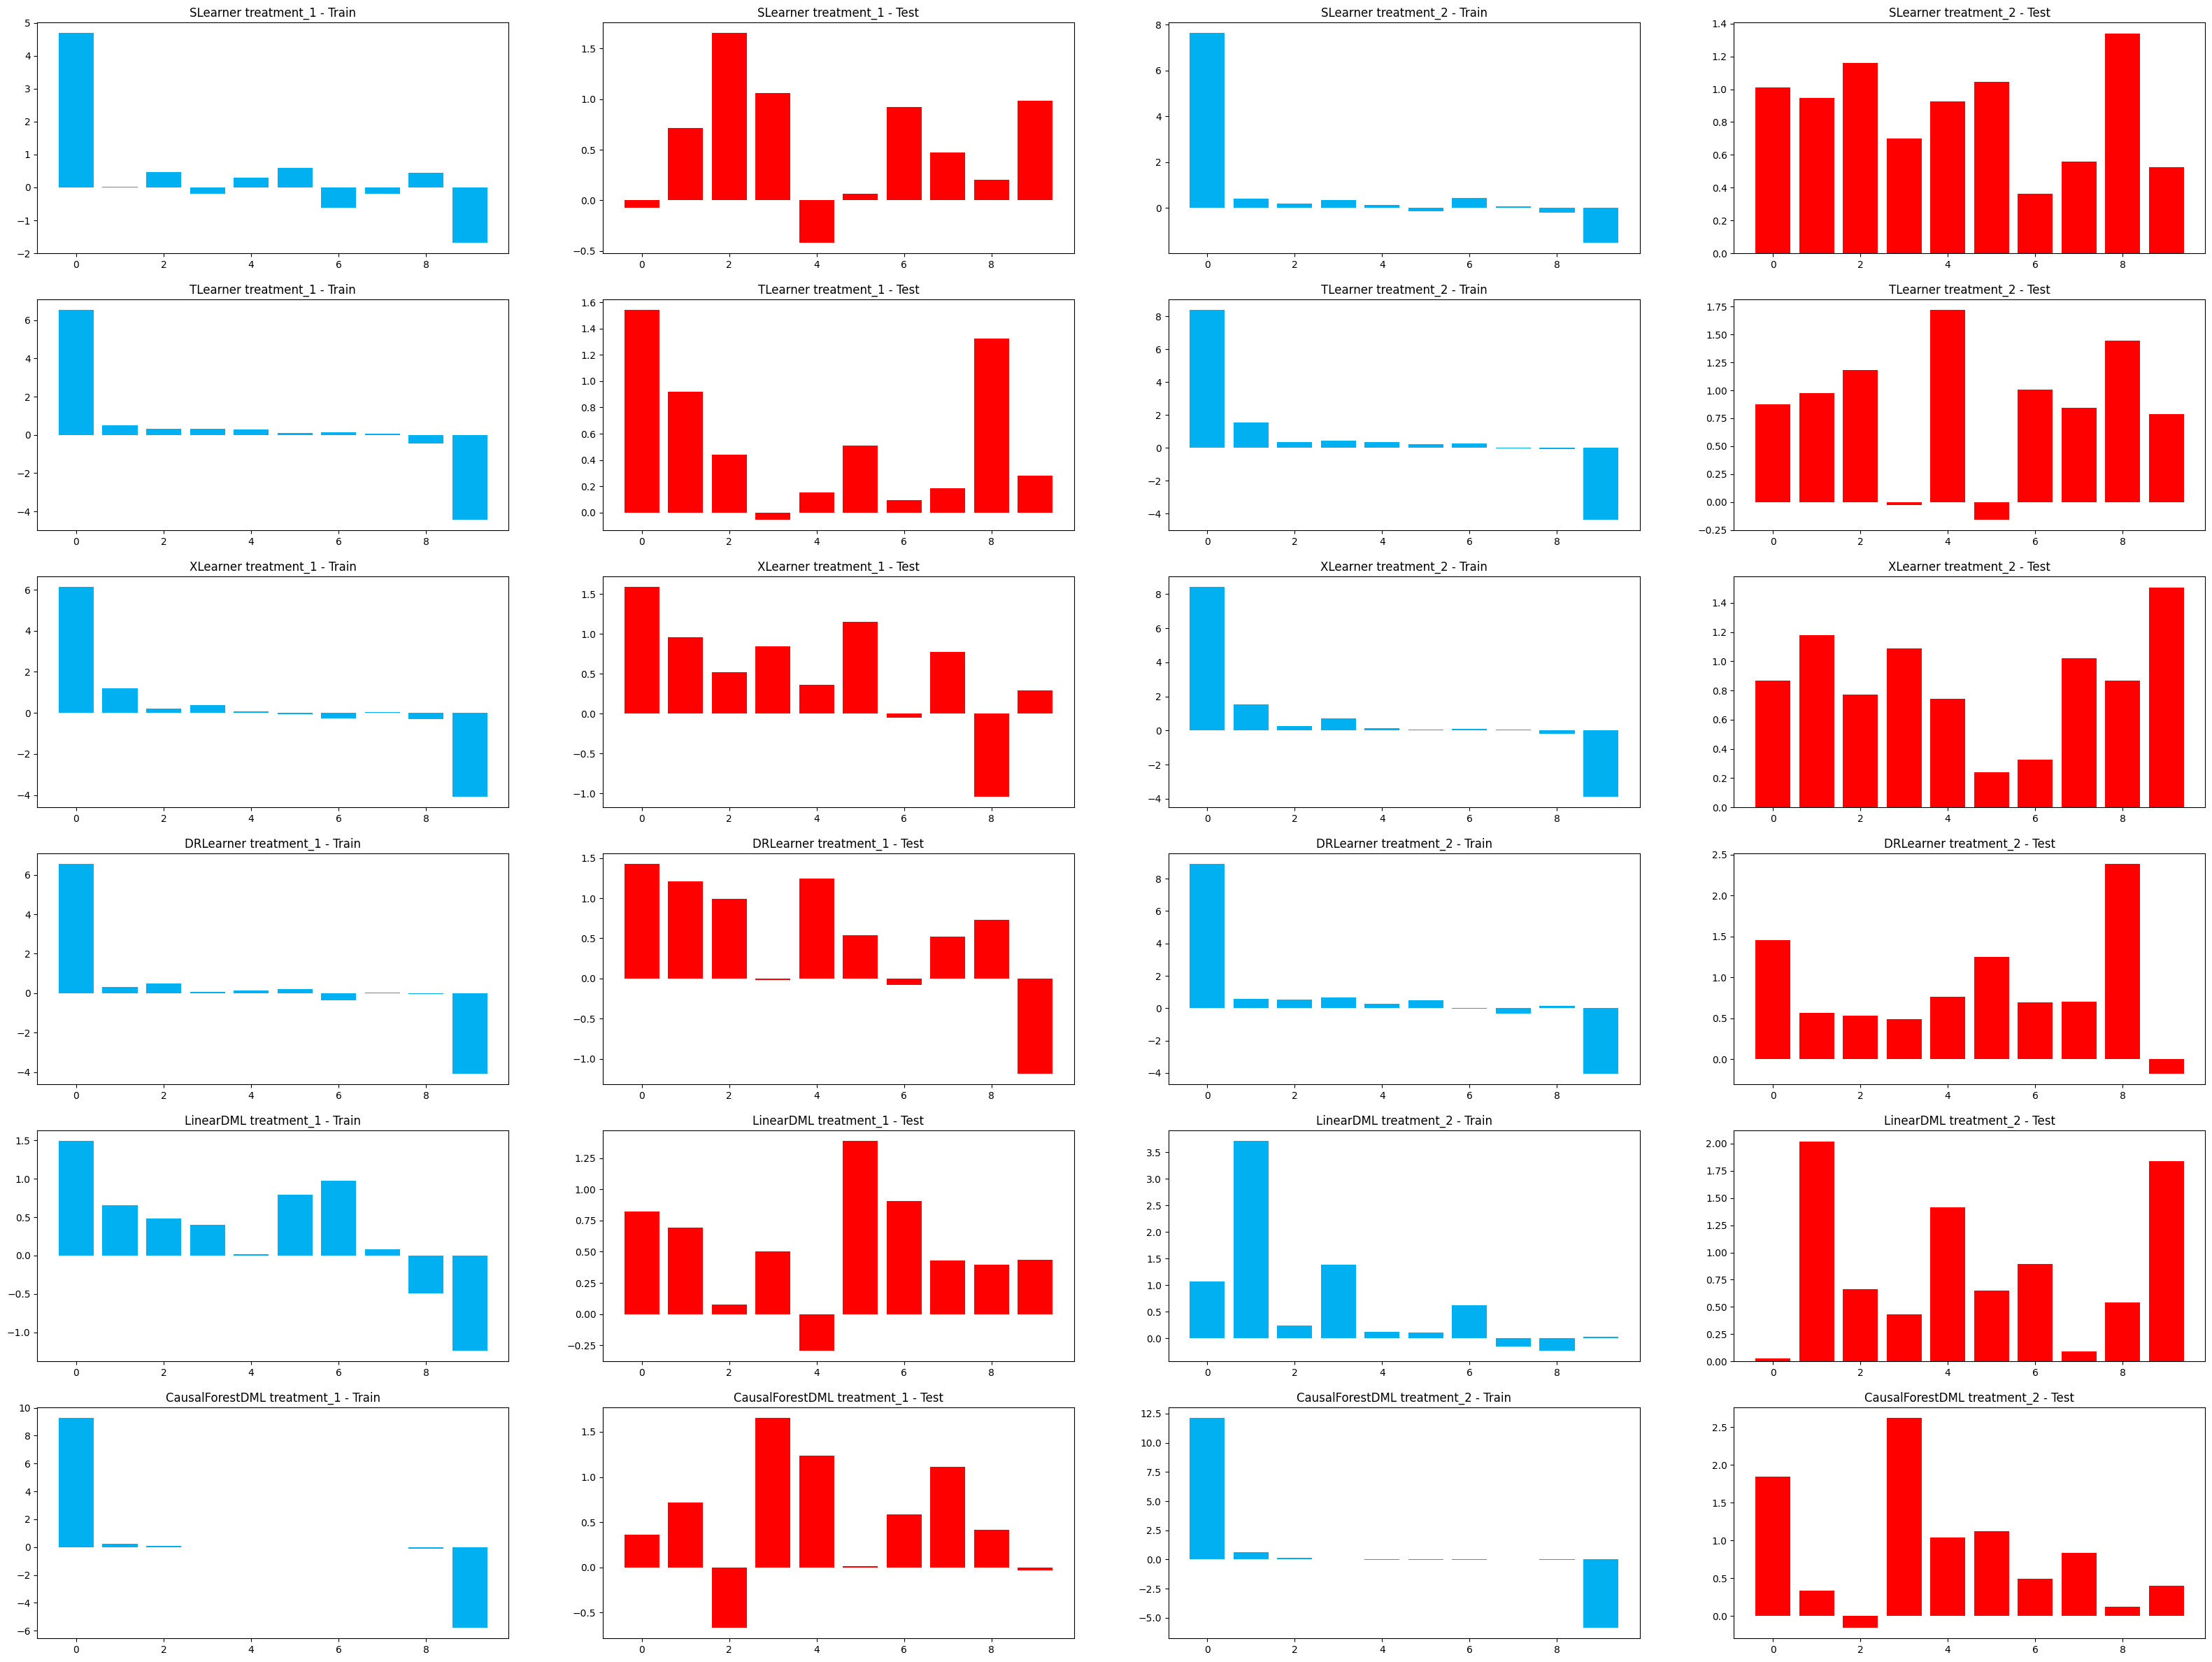

In [34]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

plt.figure(figsize=(40, 30))

i = 1

for model_name in models.keys():
    
    uplifts_by_decile = {
        'treatment_1': {},
        'treatment_2': {}
    }
    
    global_min = np.inf
    global_max = -np.inf
    
    for treatment in ['treatment_1', 'treatment_2']:

        uplift_by_decile_train = get_uplift_by_decile(
            uplifts=effects_train[treatment][model_name], 
            t_true=T_train,
            t_pred=int(treatment.split('_')[-1]),
            y_true=y_train
        )

        uplift_by_decile_test = get_uplift_by_decile(
            uplifts=effects_test[treatment][model_name], 
            t_true=T_test,
            t_pred=int(treatment.split('_')[-1]),
            y_true=y_test
        )
            
        plt.subplot(6, 4, i)
        plt.bar(np.arange(10), uplift_by_decile_train, color=COLORS[0])
        plt.title(f'{model_name} {treatment} - Train')
        
        plt.subplot(6, 4, i + 1)
        plt.bar(np.arange(10), uplift_by_decile_test, color=COLORS[1])
        plt.title(f'{model_name} {treatment} - Test')
        
        i += 2
        
plt.show()